In [53]:
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

from datetime import datetime as dt, timedelta
from calendar import isleap

#---------------------------------------------------
# for plotting purposes we use this iPython magic
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (19, 19)
#---------------------------------------------------

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['mean']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [54]:
def date_as_float(date):
    size_of_day = 1. / 366.
    size_of_second = size_of_day / (24. * 60. * 60.)
    days_from_jan1 = date - dt(date.year, 1, 1)

    if not isleap(date.year) and days_from_jan1.days >= 31 + 28:
        days_from_jan1 += timedelta(1)

    return (
            date.year + days_from_jan1.days * size_of_day +
            days_from_jan1.seconds * size_of_second
    )


def difference_in_years(start, end):
    return date_as_float(end) - date_as_float(start)


def get_harmonics(df, polarisation, date):
    # construct independent variables
    dates, sines, cosines, intercept = [], [], [], []
    two_pi = np.multiply(2, np.pi)

    for date in sorted(df.index):
        date = dt.strftime(date, "%y%m%d")

        delta = difference_in_years(
            dt.strptime('140101', "%y%m%d"),
            dt.strptime(date, "%y%m%d")
        )

        dates.append(delta)
        sines.append(np.sin(np.multiply(two_pi, delta)))
        cosines.append(np.cos(np.multiply(two_pi, delta)))
        intercept.append(1)

    x_array = np.array([dates, cosines, sines, intercept])

    x, residuals, _, _ = np.linalg.lstsq(x_array.T, df[pol], rcond=-1)

    y_pred = []
    for date in sorted(df.index):
        date_str = dt.strftime(date, "%y%m%d")

        delta = difference_in_years(
            dt.strptime('140101', "%y%m%d"),
            dt.strptime(date_str, "%y%m%d")
        )

        date = delta * x[0]
        cos_term = np.cos(np.multiply(two_pi, delta)) * x[1]
        sin_term = np.sin(np.multiply(two_pi, delta)) * x[2]
        intercept = 1*x[3]


        y = date + sin_term + cos_term + intercept 
        y_pred.append(y)

    amplitude = np.hypot(x[1], x[2])
    phase = np.arctan2(x[2], x[1])
    residuals = np.sqrt(np.divide(residuals, len(df)))[0]
    slope = x[0]
    mean = x[3]

    return amplitude, phase, residuals, slope, mean

In [55]:
stations = gpd.read_file('/home/vollrath/Indonesia_sm/stations_pix_corr.shp')
d = {}
for i, row in stations.iterrows():
    station = row['stasiun']
     
    
    file =  list(Path('/home/vollrath/Indonesia_sm/s1_timeseries/').glob(f'*{station}.s1.ts.pickle'))[0]
    df = pd.read_pickle(file)
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').dropna()
    for pol in ['VV', 'VH']:
        row[f'amplitude_{pol}'], row[f'phase_{pol}'], row[f'residuals_{pol}'], row[f'slope_{pol}'], row[f'mean_{pol}'] = get_harmonics(df, pol, dt.strptime('2018-01-01', '%Y-%m-%d'))
    
    d[station] = row
    
df = pd.DataFrame.from_dict(d, orient='index')

In [ ]:
import datetime
#df = df[df['track'] == 18]
print(len(df))
dfilter = datetime.datetime.strptime('2016-01-01', '%Y-%m-%d')
df = df[df.index >= dfilter]
print(len(df))

In [ ]:
#df['VV'] = to_power(df['VV'].values)

In [ ]:
df['VV_pred'] = y_pred
df['VV_pred'].plot()
#df['VV'].plot()
df['VV'].plot() #.resample('Q').mean().plot()
df['VV'].mean()

In [57]:
from scipy.stats import pearsonr

r, p = pearsonr(df['corr_gwl'], df['amplitude_VV'])
r2 = df['corr_gwl'].corr(df['amplitude_VV'])
print(r, r2)

-0.003629197027678518 -0.0036291970276785116


### file =  list(Path('/home/vollrath/Indonesia_sm/s1_timeseries/').glob('*BRG_150503_01.s1.ts.pickle'))[0]
df = pd.read_pickle(file)

In [23]:
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

<AxesSubplot:xlabel='corr_sm', ylabel='mean_VH'>

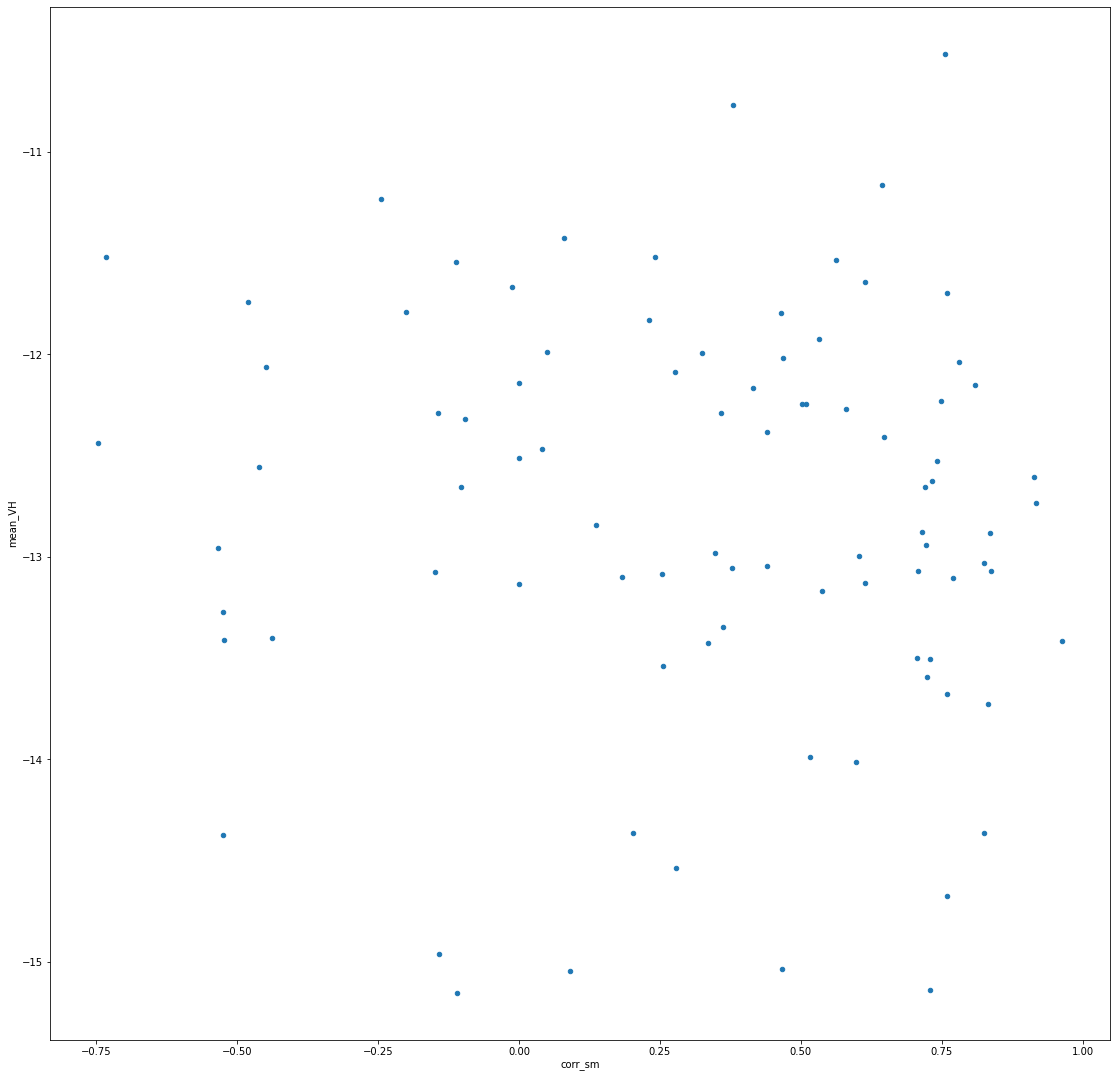

In [64]:
df.plot('corr_sm', 'mean_VH', kind='scatter')